# LightGBM demo

In this lab, we will use LightGBM to setup a simple model to predict 1604 stores daily sales.

This lab contains the following stages,
* Initialization, to load python packages, set configurations, etc.
* Exploratory Data Analysis, to analyze data sets by some statistical and visual methods
* Feature Engineering
* Training
* Prediction
* Evaluate All Sites

It might take 10 minutes to go through this notebook step by step, there is no extra resource required other than the SageMaker notebook instance we setup previously.

For more information see the LightGBM [documentation](https://lightgbm.readthedocs.io/en/latest/) or [project](https://www.microsoft.com/en-us/research/project/lightgbm/).

## Initialization

This is the bootstrap section for the whole notebook.

In [60]:
### Import modules

# decouple load configuration from settings.ini file
from decouple import config

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#setting plot style
plt.style.use(config('plot_style', cast=str))

#setting figure size
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = config('figure.figsize', cast=str).split(',')

# warning settings, to ignore all warnings
import warnings
warnings.filterwarnings("ignore")


from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.graphics as smg
import statsmodels.api as sm
import scipy.stats as scs
from sklearn import preprocessing

import lightgbm as lgb
from lightgbm import plot_importance, plot_tree
    
import json

In [15]:
### Basic settings

# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = config('DATETIME_START_OF_TRAIN')
DATETIME_END_OF_TRAIN = config('DATETIME_END_OF_TRAIN')
DATETIME_START_OF_TEST = config('DATETIME_START_OF_TEST')
DATETIME_END_OF_TEST = config('DATETIME_END_OF_TEST')
DATETIME_START_OF_PREDICT = config('DATETIME_START_OF_PREDICT')
DATETIME_END_OF_PREDICT = config('DATETIME_END_OF_PREDICT')

# we use 1 day frequency for the time series
freq = config('freq')

# we predict for 7 days
prediction_length = config('prediction_length', cast=int)

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = config('context_length', cast=int)

sample_sites = config('sample_sites', cast=lambda v: [int(s.strip()) for s in v.split(',')])

## EDA

In this section, we will explore and try to find out the main characteristics of the data

In [108]:
### Predefined functions

# Stationarity tests
def test_stationarity(ts, prefix_title=''):
    
    #Perform Dickey-Fuller test:
    print('=' * 50)
    print(f"{prefix_title} Results of Dickey-Fuller Test")
    print('-' * 50)
    dftest = adfuller(ts, autolag='AIC', regression='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    
def ts_plot_acf_pacf(y, lag_limit=None, figsize=(20, 4), style='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    #with plt.style.context(style):    
    fig = plt.figure(figsize=figsize)
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))

    smg.tsaplots.plot_acf(y, lags=lag_limit, ax=acf_ax, alpha=0.1)
    smg.tsaplots.plot_pacf(y, lags=lag_limit, ax=pacf_ax, alpha=0.1)
    acf_ax.set_title(title + " acf")
    pacf_ax.set_title(title + " pacf")

    plt.tight_layout()
    
    return 

def tsplot(y, lags=None, figsize=(10, 8), style='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    #with plt.style.context(style):    
    fig = plt.figure(figsize=figsize)
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    pp_ax = plt.subplot2grid(layout, (2, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    smg.tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.1)
    smg.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.1)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

    plt.tight_layout()
    
    return 

In [17]:
### load sales time series

df_sales = pd.read_csv('data/timeseries_raw.csv', header=None, sep=',', parse_dates=[0])
df_sales.rename(columns={0:"date"}, inplace=True)
df_sales.set_index(['date'], inplace=True)

df_sales = df_sales[~df_sales.index.isnull()]

df_sales.head()

,1,2,3,4,5,6,7,8,9,10,...,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604
date,,,,,,,,,,,,,,,,,,,,,
2019-07-10,14.0,630.7,2074.9,1305.5,3629.0,993.5,1119.5,915.1,1118.0,3123.7,...,1575.6,561.1,1024.2,1156.1,907.8,604.6,1793.7,3159.7,1972.5,617.5
2019-07-11,18.0,764.3,1057.9,596.8,1368.8,816.2,1303.8,642.2,1004.6,2832.2,...,1482.1,573.5,1446.8,1564.6,925.8,774.0,1553.0,2983.9,1337.3,490.5
2019-07-12,22.4,673.7,1278.2,1055.9,1436.6,1186.3,2160.9,936.2,735.9,3013.7,...,1290.2,625.8,1187.5,1417.7,1048.2,756.3,2257.3,3241.3,2014.8,743.0
2019-07-13,28.5,701.3,1975.9,905.2,1222.7,501.7,1363.5,1476.7,1173.3,1868.3,...,385.1,533.9,1104.4,1170.9,635.1,1159.0,2245.7,1940.7,2256.5,497.5
2019-07-14,25.0,737.5,1641.7,1122.0,1139.1,81.3,1159.0,832.7,1104.4,1356.0,...,309.0,601.7,1287.2,735.2,645.8,945.4,1457.2,1482.5,1930.7,816.0


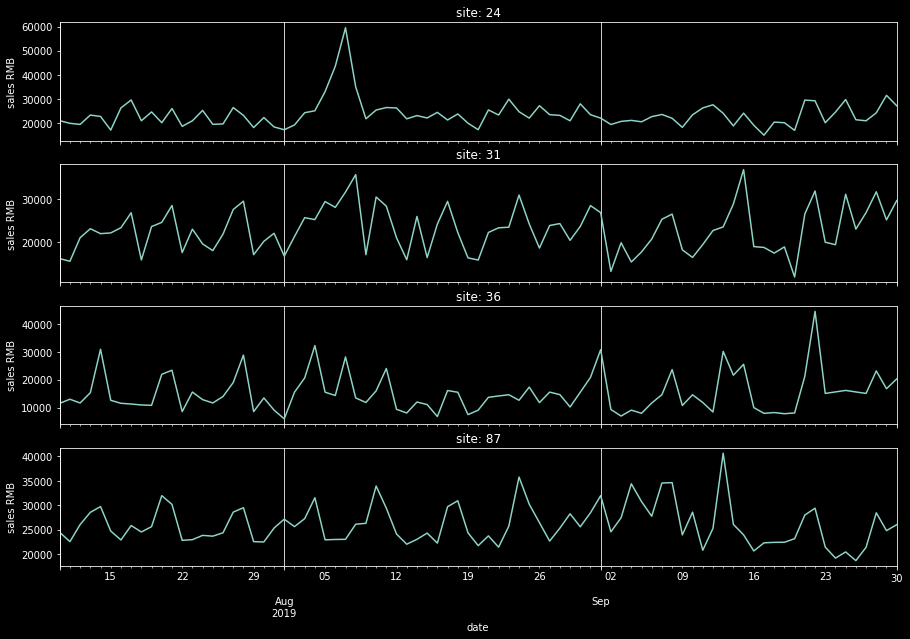

In [18]:
# line charts on sales from sample sites
fig, axs = plt.subplots(len(sample_sites), 1, figsize=(15, 10), sharex=True)
axx = axs.ravel()
for i, site in enumerate(sample_sites):
    _ = df_sales.loc[:, site].plot(ax=axx[i], style='-', title=f"site: {site}")
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("sales RMB")   
    axx[i].grid(which='major', axis='x')

### Augmented Dickey–Fuller test

An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

In the following test, we will see the result indicate that site_24 is a stationary process (similar to white noice). However, site_31/site_36/site_87 are not stationary process, since the p-values are significant higher than 0.01 and 'Test Statistic' are higher than all of the three 'Critical Values' 1%/5%/10%.

In [109]:
for i, site in enumerate(sample_sites):
    prefix_title = f"site_{site}: "

    ts = df_sales.loc[:, site].values
    
    test_stationarity(ts, prefix_title=prefix_title)

site_24:  Results of Dickey-Fuller Test
--------------------------------------------------
Test Statistic                 -4.867321
p-value                         0.000356
#Lags Used                      1.000000
Number of Observations Used    81.000000
Critical Value (1%)            -4.075122
Critical Value (5%)            -3.466155
Critical Value (10%)           -3.159611
dtype: float64
site_31:  Results of Dickey-Fuller Test
--------------------------------------------------
Test Statistic                 -3.099832
p-value                         0.106270
#Lags Used                      8.000000
Number of Observations Used    74.000000
Critical Value (1%)            -4.086632
Critical Value (5%)            -3.471582
Critical Value (10%)           -3.162763
dtype: float64
site_36:  Results of Dickey-Fuller Test
--------------------------------------------------
Test Statistic                 -2.579851
p-value                         0.289253
#Lags Used                      6.000000


### Autocorrelation function

Autocorrelation function is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations as a function of the time lag between them. The analysis of autocorrelation is a mathematical tool for finding repeating patterns, such as the presence of a periodic signal obscured by noise, or identifying the missing fundamental frequency in a signal implied by its harmonic frequencies. It is often used in signal processing for analyzing functions or series of values, such as time domain signals.

### Partial autocorrelation fuction
The partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags. This function plays an important role in data analysis aimed at identifying the extent of the lag in an autoregressive model. The use of this function was introduced as part of the Box–Jenkins approach to time series modelling, whereby plotting the partial autocorrelative functions one could determine the appropriate lags p in an AR (p) model or in an extended ARIMA (p,d,q) model.

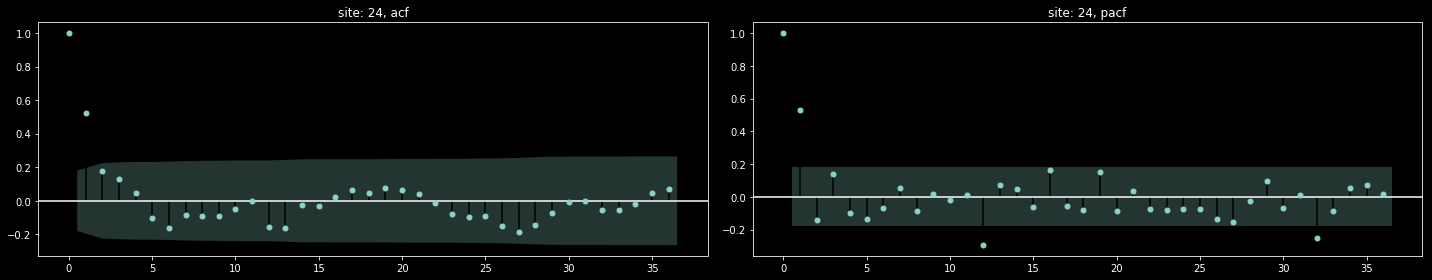

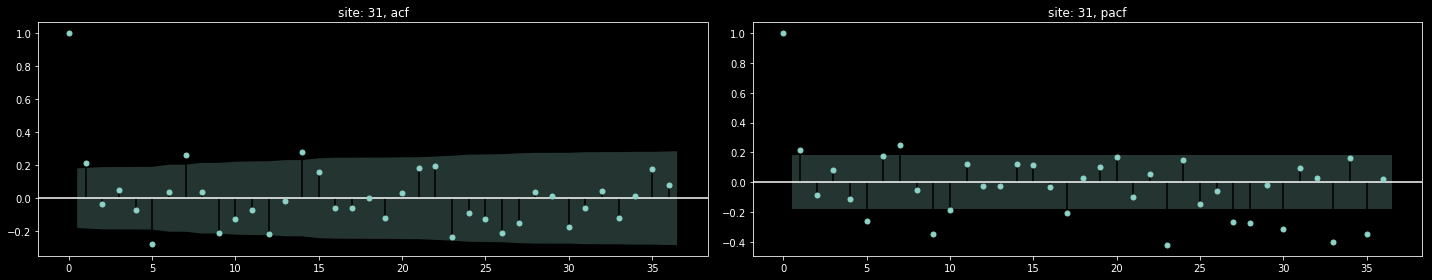

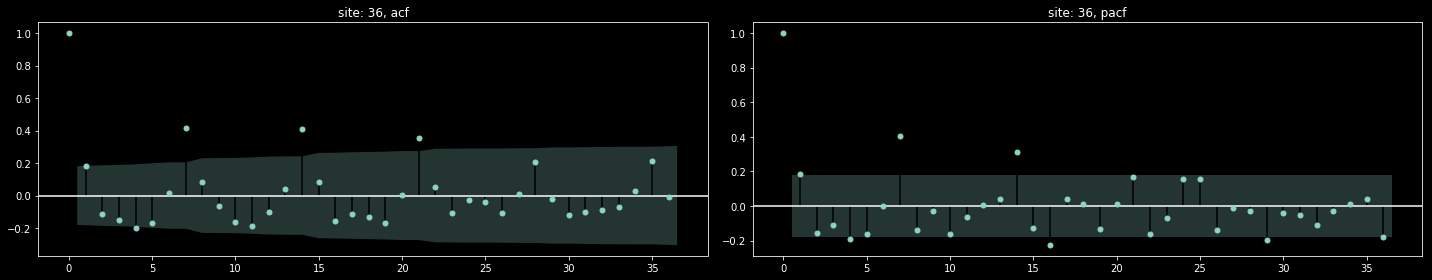

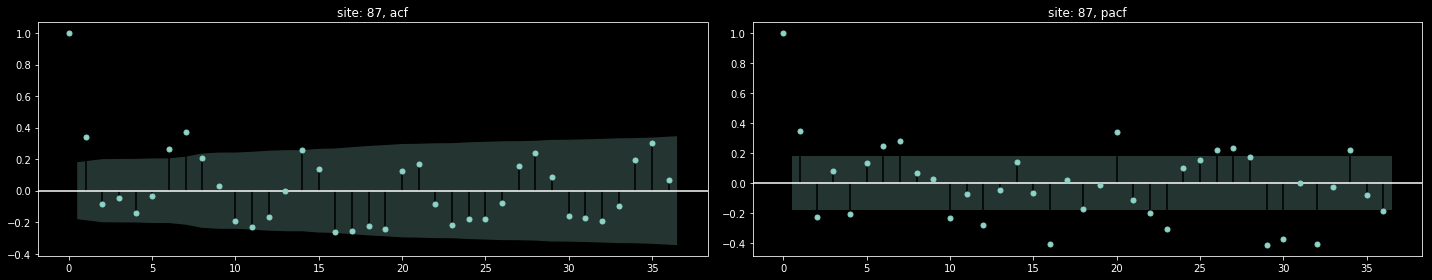

In [19]:
# autocorrelation plot and partial autocorrelation plot

for i, site in enumerate(sample_sites):
    prefix_title = f"site: {site},"
    ts = df_sales.loc[:, site].values
    _ = ts_plot_acf_pacf(ts, lag_limit=36,title=prefix_title)

In [22]:
df_weather = pd.read_csv('data/shenzhen_weather.csv', header=0, sep=',', parse_dates=[0])
df_weather.set_index(['date'], inplace=True)

df_weather

,high_temp,low_temp,is_sunshine,is_rain,is_cloudy
date,,,,,
2019-07-10,29,26,0.0,1.0,0.0
2019-07-11,30,27,0.0,0.0,1.0
2019-07-12,32,28,0.0,0.0,1.0
2019-07-13,31,28,0.0,0.0,1.0
2019-07-14,31,28,0.0,1.0,0.0
...,...,...,...,...,...
2019-09-26,30,24,0.0,0.0,1.0
2019-09-27,31,24,0.0,0.0,1.0
2019-09-28,32,24,0.0,0.0,1.0


## Feature Engineering

In [134]:
### Predefined functions

def create_features1(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek', 'month']]
    #X = df[['dayofyear','dayofmonth','weekofyear']]

    if label:
        y = df[label]
        return X, y
    return X

def create_features2(df, df_weather, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek', 'month', 'dayofmonth', 'weekofyear']]
    #X = df[['dayofyear','dayofmonth','weekofyear']]
    
    X = X.join(df_weather, how='left')

    if label:
        y = df[label]
        return X, y
    return X

In [135]:
### split data set into train and test

df_train = df_sales.loc[df_sales.index <= DATETIME_START_OF_TEST, :].copy()
df_test = df_sales.loc[(df_sales.index >= DATETIME_START_OF_TEST) & (df_sales.index <= DATETIME_START_OF_PREDICT), :].copy()

In [193]:
index_site = 3
X_train1, y_train1 = create_features1(df_train, label=sample_sites[index_site])
X_test1, y_test1 = create_features1(df_test, label=sample_sites[index_site])

lgb_train1 = lgb.Dataset(X_train1, y_train1)
lgb_test1 = lgb.Dataset(X_test1, y_test1, reference=lgb_train1)

In [194]:
X_train2, y_train2 = create_features2(df_train, df_weather, label=sample_sites[index_site])
X_test2, y_test2 = create_features2(df_test, df_weather, label=sample_sites[index_site])

lgb_train2 = lgb.Dataset(X_train2, y_train2)
lgb_test2 = lgb.Dataset(X_test2, y_test2, reference=lgb_train2)

## Training


In [195]:
### Configuration

params = {
    'num_leaves': 31,
    'metric': ['l1', 'l2'],
    'verbose': -1
}



In [196]:
### Fit Model

evals_result1 = {}  # to record eval results for plotting
gbm1 = lgb.train(params,
                lgb_train1,
                num_boost_round=200,
                valid_sets=[lgb_train1, lgb_test1],
                #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                #categorical_feature=["dayofweek"],
                evals_result=evals_result1,
                verbose_eval=10)

[10]	training's l1: 2300.58	training's l2: 1.02902e+07	valid_1's l1: 2844.16	valid_1's l2: 1.03107e+07
[20]	training's l1: 2099.72	training's l2: 9.30205e+06	valid_1's l1: 2727.99	valid_1's l2: 9.14022e+06
[30]	training's l1: 2038.91	training's l2: 9.04018e+06	valid_1's l1: 2816.76	valid_1's l2: 9.36326e+06
[40]	training's l1: 2013.35	training's l2: 8.97268e+06	valid_1's l1: 2870.81	valid_1's l2: 9.56487e+06
[50]	training's l1: 2003.99	training's l2: 8.9521e+06	valid_1's l1: 2895.96	valid_1's l2: 9.67201e+06
[60]	training's l1: 2000.48	training's l2: 8.94485e+06	valid_1's l1: 2912.03	valid_1's l2: 9.74961e+06
[70]	training's l1: 1996.48	training's l2: 8.93973e+06	valid_1's l1: 2917.08	valid_1's l2: 9.75105e+06
[80]	training's l1: 1992.78	training's l2: 8.93615e+06	valid_1's l1: 2922.63	valid_1's l2: 9.75732e+06
[90]	training's l1: 1990.53	training's l2: 8.93413e+06	valid_1's l1: 2923.74	valid_1's l2: 9.75066e+06
[100]	training's l1: 1989.05	training's l2: 8.93262e+06	valid_1's l1: 2925

In [197]:
### Fit Model

evals_result2 = {}  # to record eval results for plotting
gbm2 = lgb.train(params,
                lgb_train2,
                num_boost_round=200,
                valid_sets=[lgb_train2, lgb_test2],
                #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                #categorical_feature=["dayofweek"],
                evals_result=evals_result2,
                verbose_eval=10)

[10]	training's l1: 2274.72	training's l2: 9.82528e+06	valid_1's l1: 2845.15	valid_1's l2: 1.038e+07
[20]	training's l1: 1991.49	training's l2: 8.16391e+06	valid_1's l1: 2654.88	valid_1's l2: 9.11223e+06
[30]	training's l1: 1928.87	training's l2: 7.54822e+06	valid_1's l1: 2695.18	valid_1's l2: 9.06646e+06
[40]	training's l1: 1900.6	training's l2: 7.21866e+06	valid_1's l1: 2676.47	valid_1's l2: 8.84117e+06
[50]	training's l1: 1882.38	training's l2: 7.01427e+06	valid_1's l1: 2667.38	valid_1's l2: 8.75634e+06
[60]	training's l1: 1870.71	training's l2: 6.87404e+06	valid_1's l1: 2582.03	valid_1's l2: 8.27646e+06
[70]	training's l1: 1858.99	training's l2: 6.77843e+06	valid_1's l1: 2541.59	valid_1's l2: 8.01959e+06
[80]	training's l1: 1843.34	training's l2: 6.68198e+06	valid_1's l1: 2518.47	valid_1's l2: 7.89708e+06
[90]	training's l1: 1834	training's l2: 6.61544e+06	valid_1's l1: 2471.74	valid_1's l2: 7.66323e+06
[100]	training's l1: 1827.07	training's l2: 6.52304e+06	valid_1's l1: 2460.08	v

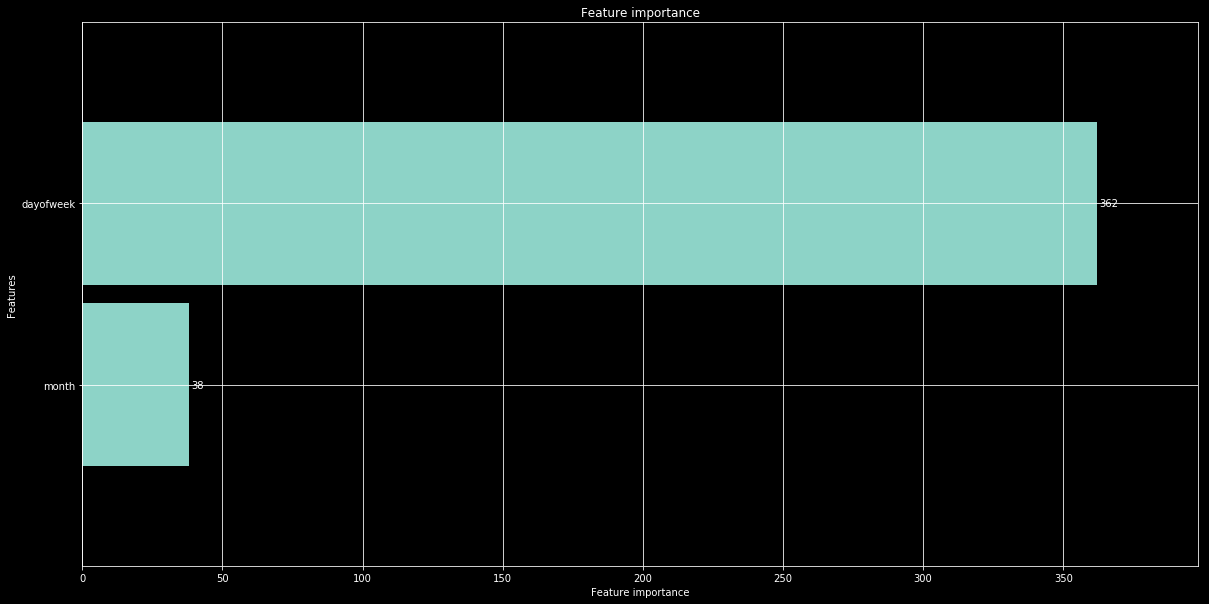

In [198]:
### Feature Importance
_ = plot_importance(gbm1, height=0.9)

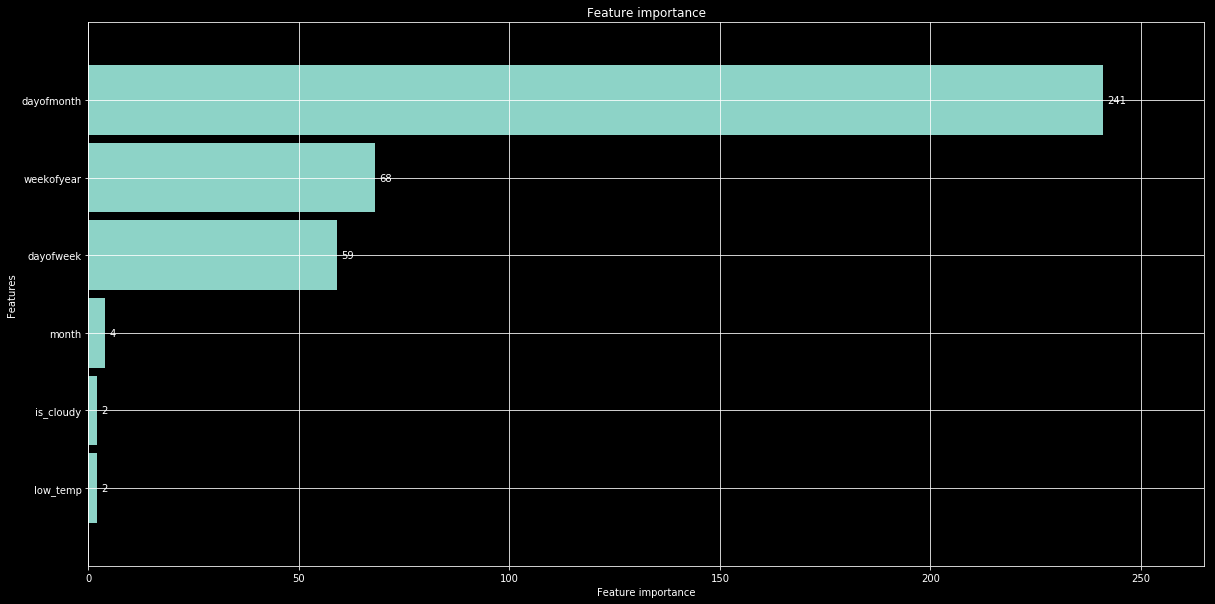

In [199]:
### Feature Importance
_ = plot_importance(gbm2, height=0.9)

## Prediction

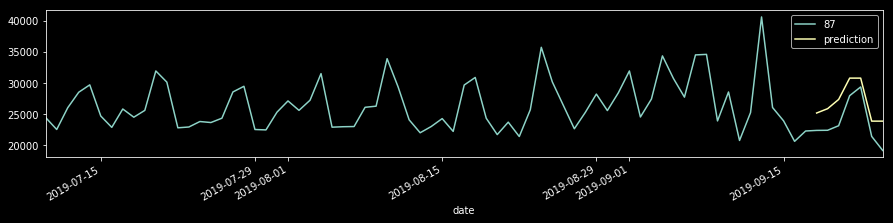

In [200]:
df_test['prediction'] = gbm1.predict(X_test1)
df_all = pd.concat([df_test, df_train], sort=False)
_ = df_all[[sample_sites[index_site],'prediction']].plot(figsize=(15, 3))

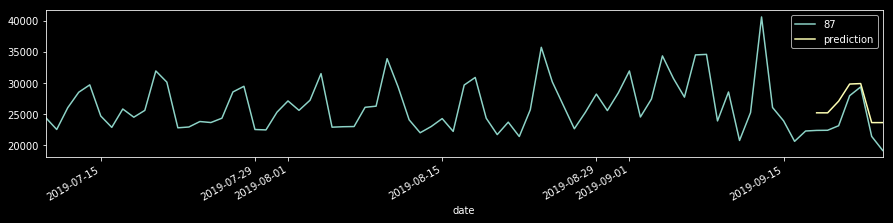

In [201]:
df_test['prediction'] = gbm2.predict(X_test2)
df_all = pd.concat([df_test, df_train], sort=False)
_ = df_all[[sample_sites[index_site],'prediction']].plot(figsize=(15, 3))

## Evaluate All Sites

In this section, we will iterate all sample sites, train a LightGBM model, predict and plot results for each of them.

[10]	training's l1: 3618.43	training's l2: 3.60759e+07	valid_1's l1: 5023.06	valid_1's l2: 3.05582e+07
[20]	training's l1: 3623.96	training's l2: 3.53059e+07	valid_1's l1: 5164.25	valid_1's l2: 3.17275e+07
[30]	training's l1: 3630.09	training's l2: 3.48953e+07	valid_1's l1: 5209.82	valid_1's l2: 3.22614e+07
[40]	training's l1: 3635.65	training's l2: 3.46226e+07	valid_1's l1: 5224.69	valid_1's l2: 3.24625e+07
[50]	training's l1: 3638.18	training's l2: 3.44308e+07	valid_1's l1: 5222.52	valid_1's l2: 3.24537e+07
[60]	training's l1: 3649.92	training's l2: 3.42833e+07	valid_1's l1: 5242.83	valid_1's l2: 3.27635e+07
[70]	training's l1: 3650.01	training's l2: 3.41802e+07	valid_1's l1: 5234.37	valid_1's l2: 3.27206e+07
[80]	training's l1: 3656.57	training's l2: 3.40959e+07	valid_1's l1: 5247.34	valid_1's l2: 3.29583e+07
[90]	training's l1: 3652.4	training's l2: 3.40342e+07	valid_1's l1: 5234.2	valid_1's l2: 3.28764e+07
[100]	training's l1: 3649.94	training's l2: 3.39847e+07	valid_1's l1: 5229.

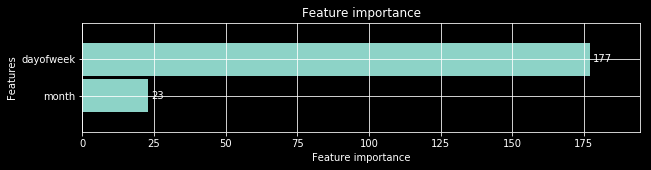

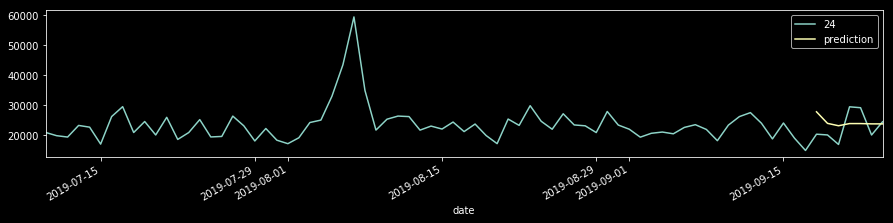

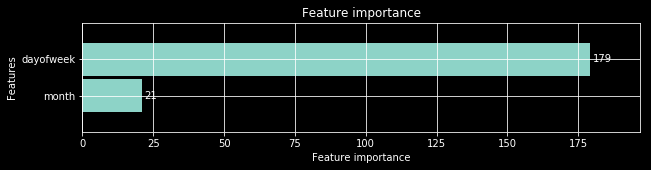

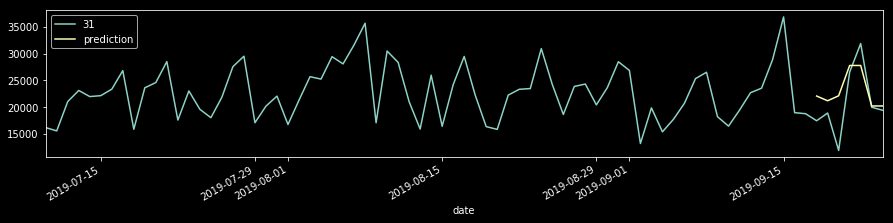

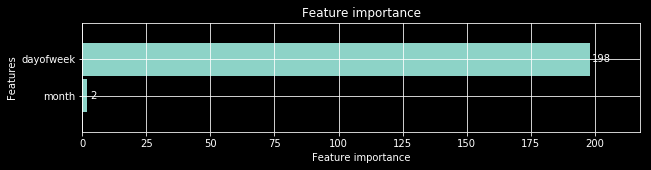

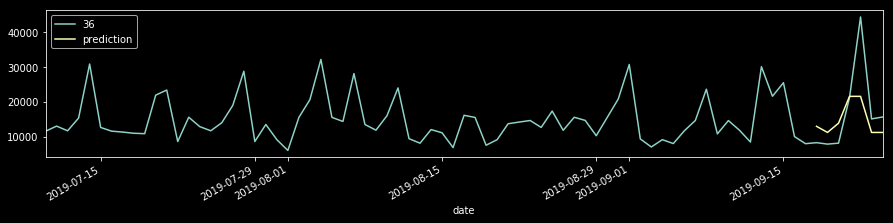

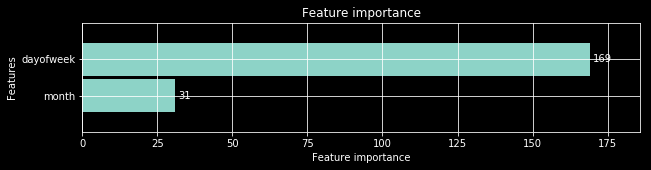

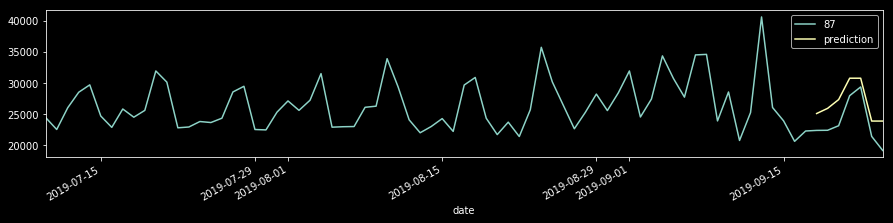

In [202]:
for i, site in enumerate(sample_sites):
    X_train, y_train = create_features1(df_train, label=site)
    X_test, y_test = create_features1(df_test, label=site)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    evals_result = {}  # to record eval results for plotting
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=[lgb_train, lgb_test],
                    #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                    #categorical_feature=["dayofweek"],
                    evals_result=evals_result,
                    verbose_eval=10)
    
    _ = plot_importance(gbm, height=0.9, figsize=(10, 2))
    
    df_test['prediction'] = gbm.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    _ = df_all[[site,'prediction']].plot(figsize=(15, 3))

[10]	training's l1: 3396.48	training's l2: 3.21642e+07	valid_1's l1: 4534.54	valid_1's l2: 2.48753e+07
[20]	training's l1: 3309.23	training's l2: 2.94917e+07	valid_1's l1: 4287.67	valid_1's l2: 2.39578e+07
[30]	training's l1: 3276.51	training's l2: 2.72136e+07	valid_1's l1: 4142.94	valid_1's l2: 2.44558e+07
[40]	training's l1: 3247.87	training's l2: 2.58077e+07	valid_1's l1: 4163.46	valid_1's l2: 2.54729e+07
[50]	training's l1: 3230.88	training's l2: 2.48195e+07	valid_1's l1: 4229.1	valid_1's l2: 2.65295e+07
[60]	training's l1: 3199.56	training's l2: 2.39917e+07	valid_1's l1: 4333.21	valid_1's l2: 2.75586e+07
[70]	training's l1: 3178.91	training's l2: 2.33015e+07	valid_1's l1: 4343.87	valid_1's l2: 2.76261e+07
[80]	training's l1: 3154.14	training's l2: 2.27563e+07	valid_1's l1: 4383.17	valid_1's l2: 2.83578e+07
[90]	training's l1: 3134.31	training's l2: 2.22793e+07	valid_1's l1: 4419.05	valid_1's l2: 2.8672e+07
[100]	training's l1: 3102.28	training's l2: 2.18205e+07	valid_1's l1: 4419.

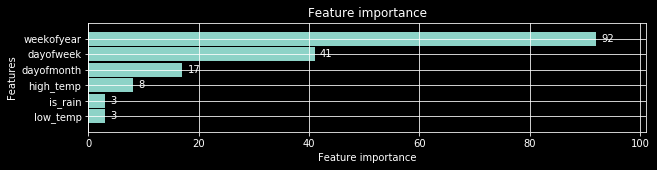

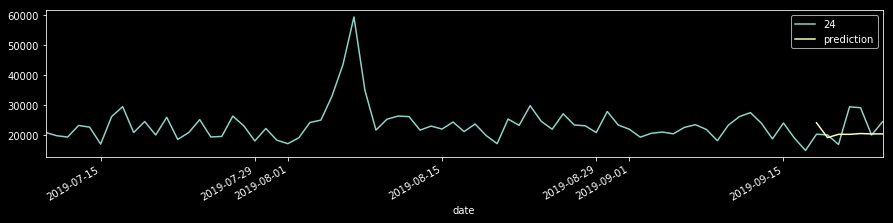

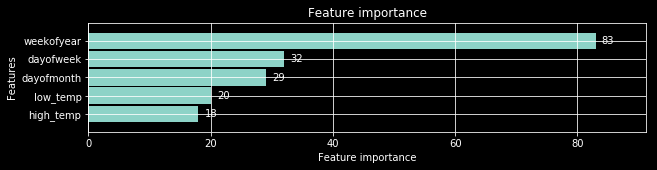

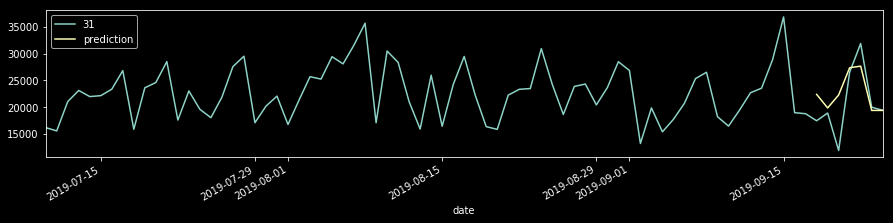

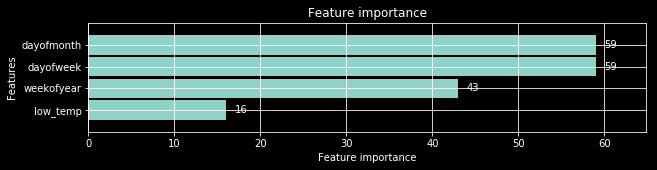

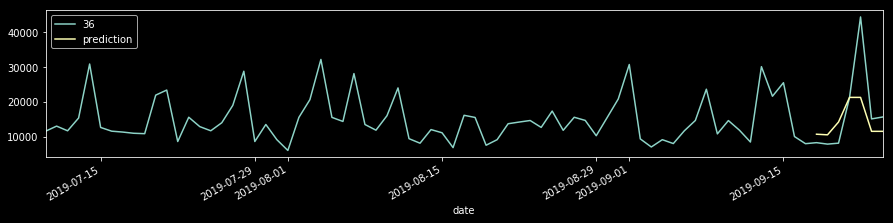

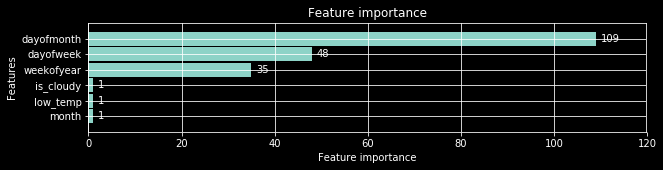

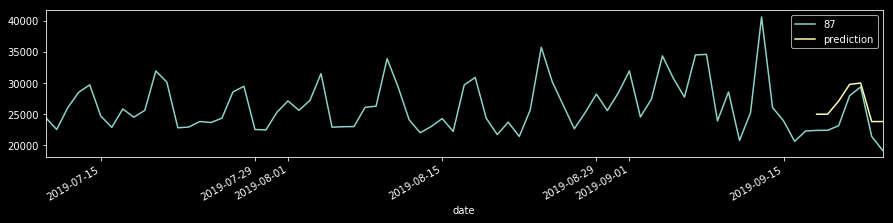

In [203]:
for i, site in enumerate(sample_sites):
    X_train, y_train = create_features2(df_train, df_weather, label=site)
    X_test, y_test = create_features2(df_test, df_weather, label=site)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    evals_result = {}  # to record eval results for plotting
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=[lgb_train, lgb_test],
                    #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                    #categorical_feature=["dayofweek"],
                    evals_result=evals_result,
                    verbose_eval=10)
    
    _ = plot_importance(gbm, height=0.9, figsize=(10, 2))
    
    df_test['prediction'] = gbm.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    _ = df_all[[site,'prediction']].plot(figsize=(15, 3))